In [52]:
import pandas as pd
import os

In [53]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [55]:
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats
import statsmodels.api as sm

## Get association files

In [56]:
icb=pd.read_csv("../data/TIME.icb.OR.tsv",delimiter="\t",header=None)

In [57]:
icb.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,NaN,logOR,logOR,logOR,logOR,logOR,logOR,P,P,P,P,P,P,A1,A1,A1,A1,A1,A1
1,study,hugo,miao,riaz,rizvi,snyder,vanallen,hugo,miao,riaz,rizvi,snyder,vanallen,hugo,miao,riaz,rizvi,snyder,vanallen
2,ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10:71880791:C:G,-0.11971302321036156,-0.23626436536932702,0.4960823627976655,-0.2754161363819197,-0.21818361305331627,-0.058087254052360156,0.637409,0.228868,0.0349897,0.41732600000000003,0.255151,0.7378060000000001,G,G,G,G,G,G
4,11:65561369:G:A,-0.3293219235557343,0.011333567997411573,-1.0156793069570496,0.16407315147750257,0.26503019772305864,0.22668237466700913,0.27519299999999997,0.957946,0.00111049,0.662309,0.200401,0.363292,A,A,A,A,A,A


### CIBERSORT

In [58]:
files=[x for x in os.listdir("../associations/cibersort/") if ".glm.linear" in x]
print(len(files))

23


In [59]:
files=set([x for x in files if "M1" in x]+[x for x in files if "M2" in x]+[x for x in files if "CD8" in x]+[x for x in files if "CD4" in x])

In [60]:
compiled_ciber=pd.DataFrame()

for x in files:
    df=pd.read_csv("../associations/cibersort/"+x,delimiter="\t",encoding= 'unicode_escape')
    df=df[df["TEST"]=="ADD"].sort_values(by="P")
    df=df[df["ID"].isin(icb[0].tolist())]
    df["file"]=x
    compiled_ciber=compiled_ciber.append(df)
    

### RNA

In [61]:
files=[x for x in os.listdir("../associations/rna/") if ".glm.linear" in x]
print(len(files))

19


In [62]:
compiled_rna=pd.DataFrame()

for x in files:
    df=pd.read_csv("../associations/rna/"+x,delimiter="\t",encoding= 'unicode_escape')
    df=df[df["TEST"]=="ADD"].sort_values(by="P")
    df=df[df["ID"].isin(icb[0].tolist())]
    df["file"]=x
    compiled_rna=compiled_rna.append(df)
    

### Odds Ratio

In [63]:
directory="/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"
files=[x for x in os.listdir(directory) if "add" in x]

In [64]:
files.remove("melanoma.assoc.logistic.add")
files.remove("rcc.assoc.logistic.add")
files.remove("nsclc.assoc.logistic.add")

In [65]:
compiled_icb=pd.DataFrame()

for x in files:
    df=pd.read_csv("/cellar/users/mpagadal/Data2/projects/germline-immune/disease-relevance/associations/metal/partial.sd.coding/"+x,delimiter="\t")
    df=df[df["TEST"]=="ADD"].sort_values(by="P")
    df=df[df["ID"].isin(icb[0].tolist())]
    df["file"]=x
    compiled_icb=compiled_icb.append(df)

In [66]:
compiled_icb["BETA"]=np.log10(compiled_icb["OR"])

### Combining associations

In [67]:
compiled=compiled_ciber.append(compiled_rna)
compiled=compiled.append(compiled_icb)

In [68]:
#log10 p-value
compiled["-log10p"]=-np.log10(compiled["P"])

In [70]:
compiled["#CHROM"]=compiled["#CHROM"].astype(int)

In [71]:
compiled["file"]=compiled["file"].str.split(".glm.linear").str[0]
compiled["file"]=compiled["file"].str.split(".assoc.logistic.add").str[0]

In [72]:
compiled=compiled.sort_values(by=["#CHROM","POS","file"],ascending=False)

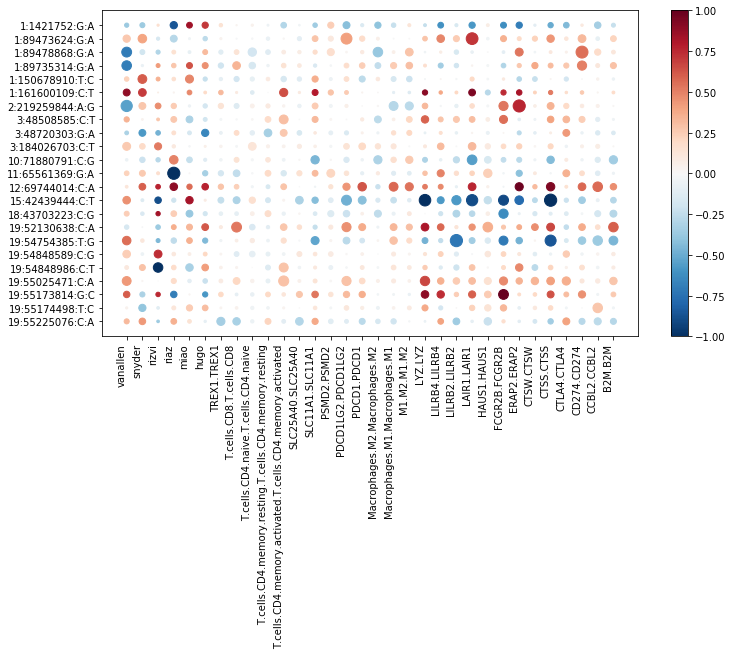

In [73]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-1, vmax=1# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=compiled['file'],
    y=compiled['ID'],
    size=compiled['-log10p'],
    color=compiled['BETA'],
)

plt.savefig("../plots/icb.odds.p.pdf")

### Get PCA association from TCGA

In [109]:
pca=pd.read_csv("../../snp-tables/immune-microenvironment-pc.tsv",delimiter="\t")

In [110]:
pca["snp_noallele"]=pca["ID"].str.rsplit(":",2).str[0]

In [111]:
pca_filt=pca[pca["snp_noallele"].isin([x.rsplit(":",2)[0] for x in compiled["ID"].tolist()])]

In [112]:
pc=pca_filt

In [113]:
pc

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,fdr,-log10(fdr),pc,snp_noallele
0,1,1421752,1:1421752:G:A,G,A,A,ADD,7288,-0.196728,0.074793,-2.630300,0.008549,.,0.176628,0.752941,PC2,1:1421752
40,1,89473624,1:89473624:G:A,G,A,A,ADD,7288,0.002081,0.069966,0.029747,0.976270,.,0.996779,0.001401,PC2,1:89473624
42,1,89478868,1:89478868:G:A,G,A,A,ADD,7288,-0.028870,0.074532,-0.387358,0.698502,.,0.964132,0.015864,PC2,1:89478868
43,1,89735314,1:89735314:G:A,G,A,A,ADD,7288,-0.070864,0.086475,-0.819467,0.412547,.,0.845002,0.073142,PC2,1:89735314
47,1,150678910,1:150678910:T:C,T,C,C,ADD,7288,-0.092987,0.061050,-1.523130,0.127771,.,0.584997,0.232846,PC2,1:150678910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4714,19,54848986,19:54848986:C:T,C,T,T,ADD,7288,0.006807,0.030045,0.226558,0.820774,.,0.965572,0.015215,PC8,19:54848986
4732,19,55025471,19:55025471:C:A,C,A,A,ADD,7288,0.066396,0.073630,0.901746,0.367222,.,0.891163,0.050043,PC8,19:55025471
4739,19,55173814,19:55173814:G:C,G,C,C,ADD,7288,-0.050818,0.024570,-2.068270,0.038650,.,0.807341,0.092943,PC8,19:55173814
4740,19,55174498,19:55174498:T:C,T,C,C,ADD,7288,-0.023589,0.030884,-0.763803,0.445009,.,0.903330,0.044153,PC8,19:55174498


In [117]:
pc=pc.sort_values(by=["#CHROM","POS","pc"],ascending=False)

In [118]:
pc["-log10p"]=-np.log10(pc["P"])

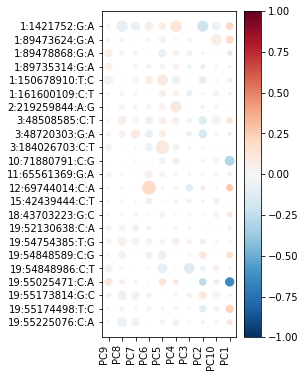

In [119]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(3, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-1, vmax=1# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=pc['pc'],
    y=pc['ID'],
    size=pc['-log10p'],
    color=pc['BETA'],
)

plt.savefig("../plots/pc.p.pdf")

## Get tcga results

In [81]:
directory="/cellar/users/mpagadal/Data2/projects/germline-immune/discovery/associations/filtered/tpm/"
files=os.listdir(directory)

tcga=pd.DataFrame()

for x in files:
    try:
        df=pd.read_csv(directory+x,delimiter="\t",header=None)
        df=df[df[6]=="ADD"]
        df["file"]=x.split(".sig.snps")[0]
        tcga=tcga.append(df)
    except:
        print(x)

In [84]:
snps=compiled["ID"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[3] for x in compiled["ID"].tolist()]

In [87]:
tcga=tcga[tcga[2].isin(snps)]

In [90]:
genes=[x.split(".")[0] for x in compiled["file"].tolist()]

In [92]:
tcga=tcga[tcga["file"].isin(genes)]

In [98]:
tcga=tcga.sort_values(by=[0,1,"file"],ascending=False)

In [101]:
tcga[11]=tcga[11].astype(float)

In [102]:
tcga["-log10p"]=-np.log10(tcga[11])

In [104]:
tcga["BETA"]=tcga[8]

In [106]:
tcga

,0,1,2,3,4,5,6,7,8,9,10,11,12,file,-log10p,BETA
6097,19,55225076,19:55225076:C:A,C,A,A,ADD,7113,0.005733,0.017736,0.323237,0.746525,.,TREX1,0.126956,0.005733
6097,19,55225076,19:55225076:C:A,C,A,A,ADD,7113,0.002639,0.017736,0.148768,0.881741,.,SLC25A40,0.054659,0.002639
6097,19,55225076,19:55225076:C:A,C,A,A,ADD,7113,0.014670,0.017749,0.826518,0.408538,.,SLC11A1,0.388768,0.014670
6097,19,55225076,19:55225076:C:A,C,A,A,ADD,7113,0.014947,0.017738,0.842693,0.399429,.,PSMD2,0.398560,0.014947
6097,19,55225076,19:55225076:C:A,C,A,A,ADD,7113,0.032417,0.017742,1.827130,0.067723,.,LYZ,1.169264,0.032417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,1421752,1:1421752:G:A,G,A,A,ADD,7113,-0.010890,0.021029,-0.517875,0.604561,.,ERAP2,0.218560,-0.010890
0,1,1421752,1:1421752:G:A,G,A,A,ADD,7113,-0.051722,0.021088,-2.452710,0.014202,.,CTSW,1.847638,-0.051722
0,1,1421752,1:1421752:G:A,G,A,A,ADD,7113,0.033925,0.021045,1.612010,0.107004,.,CTSS,0.970600,0.033925
0,1,1421752,1:1421752:G:A,G,A,A,ADD,7113,-0.061034,0.021086,-2.894510,0.003809,.,CCBL2,2.419183,-0.061034


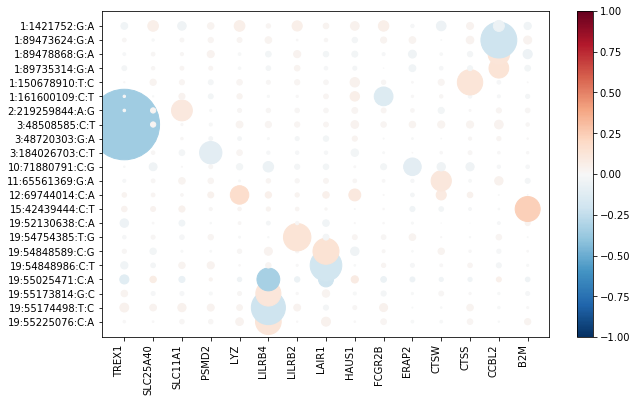

In [108]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-1, vmax=1# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=tcga['file'],
    y=tcga[2],
    size=tcga['-log10p'],
    color=tcga['BETA'],
)

plt.savefig("../plots/tcga.p.pdf")

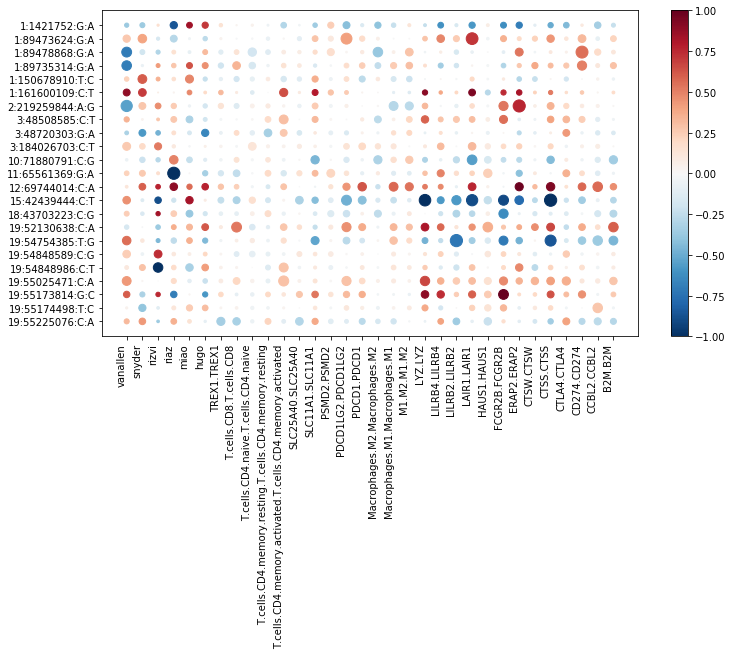

In [48]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-1, vmax=1# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=compiled['file'],
    y=compiled['ID'],
    size=compiled['-log10p'],
    color=compiled['BETA'],
)

plt.savefig("../plots/icb.odds.p.pdf")

In [50]:
df_size=compiled.copy()

In [51]:
df_size["-log10p"]=np.where(df_size["file"]=="vanallen",2,df_size["-log10p"])
df_size["-log10p"]=np.where(df_size["file"]=="snyder",1.3,df_size["-log10p"])
df_size["-log10p"]=np.where(df_size["file"]=="rizvi",1,df_size["-log10p"])
df_size["-log10p"]=np.where(df_size["file"]=="riaz",0.699,df_size["-log10p"])

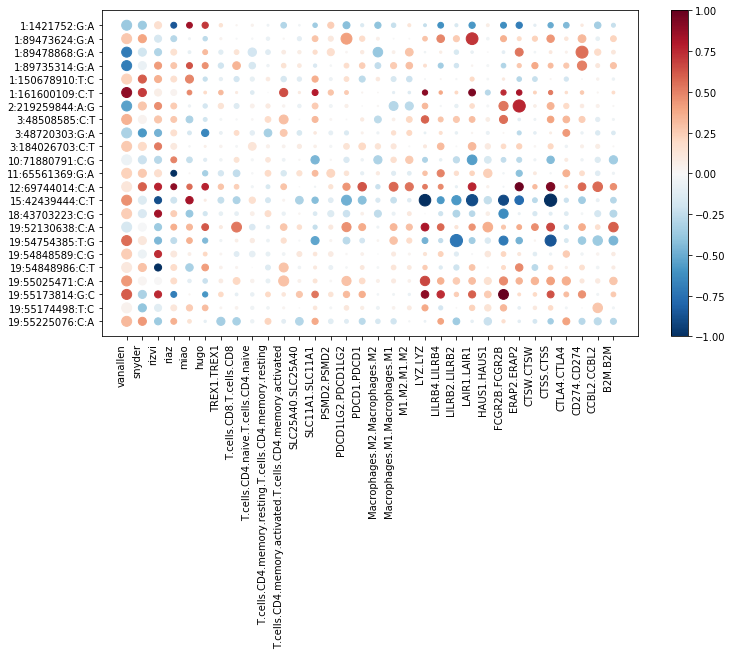

In [52]:
#Plot

def heatmap(x, y, size,color):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in x.unique()]
    y_labels = [v for v in y.unique()]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 50
    plt.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, 
        c=color,
        cmap="RdBu_r", vmin=-1, vmax=1# Vector of square sizes, proportional to size parameter
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    plt.colorbar()
    
    plt.xticks(rotation=90)
    
    
heatmap(
    x=df_size['file'],
    y=df_size['ID'],
    size=df_size['-log10p'],
    color=df_size['BETA'],
)

plt.savefig("../plots/icb.odds.p.size.pdf")

In [54]:
compiled.sort_values(by="P")

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,file,FIRTH?,OR,LOG(OR)_SE,Z_STAT,-log10p
8364,15,42439444.0,15:42439444:C:T,C,T,T,ADD,144.0,-1.074340,0.320272,-3.354470,0.001029,.,CTSS.CTSS,NaN,NaN,NaN,NaN,2.987677
9423,19,54754385.0,19:54754385:T:G,T,G,G,ADD,144.0,-0.721381,0.215344,-3.349900,0.001045,.,LILRB2.LILRB2,NaN,NaN,NaN,NaN,2.981071
320,11,65561369.0,11:65561369:G:A,G,A,A,ADD,67.0,-1.015679,NaN,NaN,0.001110,.,riaz,N,0.096454,0.717185,-3.260930,2.954485
1463,2,219259844.0,2:219259844:A:G,A,G,G,ADD,144.0,0.764404,0.230210,3.320470,0.001152,.,ERAP2.ERAP2,NaN,NaN,NaN,NaN,2.938578
1173,1,89478868.0,1:89478868:G:A,G,A,A,ADD,144.0,0.554584,0.170231,3.257830,0.001416,.,CD274.CD274,NaN,NaN,NaN,NaN,2.849066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,19,54848589.0,19:54848589:C:G,C,G,G,ADD,151.0,-0.001448,0.136089,-0.010640,0.991525,.,Macrophages.M2.Macrophages.M2,NaN,NaN,NaN,NaN,0.003696
1323,1,161600109.0,1:161600109:C:T,C,T,T,ADD,151.0,0.002935,0.342831,0.008560,0.993182,.,T.cells.CD4.memory.resting.T.cells.CD4.memory....,NaN,NaN,NaN,NaN,0.002971
9079,18,43703223.0,18:43703223:C:G,C,G,G,ADD,144.0,0.002443,0.322243,0.007581,0.993962,.,LYZ.LYZ,NaN,NaN,NaN,NaN,0.002630
9059,19,54848986.0,19:54848986:C:T,C,T,T,ADD,151.0,0.000566,0.087101,0.006494,0.994828,.,T.cells.CD4.naive.T.cells.CD4.naive,NaN,NaN,NaN,NaN,0.002252


## Compare tcga and icb

In [136]:
compiled["snp_noallele"]=compiled["ID"].str.rsplit(":",2).str[0]
tcga["snp_noallele"]=tcga[2].str.rsplit(":",2).str[0]

In [137]:
compiled["file"]=compiled["file"].str.split(".").str[0]

In [138]:
compare=pd.merge(tcga,compiled,on=["snp_noallele","file"],how="left",suffixes=("_tcga","_icb"))

In [143]:
compare[compare[5]!=compare["ALT"]]

,0,1,2,3,4,5,6,7,8,9,...,BETA_icb,SE,T_STAT,P,ERRCODE,FIRTH?,OR,LOG(OR)_SE,Z_STAT,-log10p_icb


In [144]:
compare[5]

0      A
1      A
2      A
3      A
4      A
      ..
325    A
326    A
327    A
328    A
329    A
Name: 5, Length: 330, dtype: object

In [145]:
compare["A1"]

0      A
1      A
2      A
3      A
4      A
      ..
325    A
326    A
327    A
328    A
329    A
Name: A1, Length: 330, dtype: object

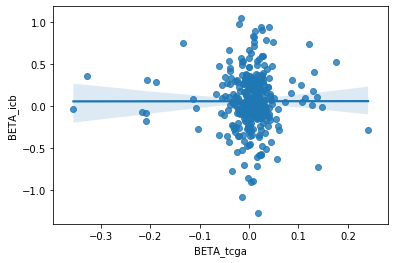

In [131]:
sns.regplot(compare["BETA_tcga"],compare["BETA_icb"])

In [133]:
compare["difference"]=compare["BETA_tcga"]-compare["BETA_icb"]

In [135]:
compare.sort_values(by="difference")

,0,1,2,3,4,5,6,7,8,9,...,SE,T_STAT,P,ERRCODE,FIRTH?,OR,LOG(OR)_SE,Z_STAT,-log10p_icb,difference
39,19,55173814,19:55173814:G:C,G,C,C,ADD,7113,-0.017186,0.016571,...,0.410722,2.55838,0.011603,.,NaN,NaN,NaN,NaN,1.935437,-1.067966
145,12,69744014,12:69744014:C:A,C,A,A,ADD,7113,-0.020356,0.033659,...,0.488347,2.00010,0.047467,.,NaN,NaN,NaN,NaN,1.323611,-0.997096
247,1,161600109,1:161600109:C:T,C,T,T,ADD,7113,0.023303,0.025199,...,0.600418,1.56482,0.119932,.,NaN,NaN,NaN,NaN,0.921065,-0.916243
147,12,69744014,12:69744014:C:A,C,A,A,ADD,7113,0.039386,0.033688,...,0.449450,2.07837,0.039541,.,NaN,NaN,NaN,NaN,1.402953,-0.894739
249,1,161600109,1:161600109:C:T,C,T,T,ADD,7113,-0.134280,0.025113,...,0.701179,1.06805,0.287378,.,NaN,NaN,NaN,NaN,0.541546,-0.883171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,19,54754385,19:54754385:T:G,T,G,G,ADD,7113,0.139727,0.017345,...,0.215344,-3.34990,0.001045,.,NaN,NaN,NaN,NaN,2.981071,0.861108
127,15,42439444,15:42439444:C:T,C,T,T,ADD,7113,0.008849,0.033215,...,0.293597,-3.03557,0.002874,.,NaN,NaN,NaN,NaN,2.541491,0.900082
129,15,42439444,15:42439444:C:T,C,T,T,ADD,7113,0.003447,0.033165,...,0.344025,-2.62107,0.009756,.,NaN,NaN,NaN,NaN,2.010748,0.905163
132,15,42439444,15:42439444:C:T,C,T,T,ADD,7113,-0.013530,0.033249,...,0.320272,-3.35447,0.001029,.,NaN,NaN,NaN,NaN,2.987677,1.060810


## Burden score for Macrophage Infiltration

In [21]:
compiled_mac=compiled[compiled["file"].str.contains("Macrophages.M1")]

In [22]:
compiled_mac.head()

,#CHROM,POS,ID,REF,ALT,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,file,FIRTH?,OR,LOG(OR)_SE,Z_STAT,-log10p
1486,2,219259844.0,2:219259844:A:G,A,G,G,ADD,151.0,-0.282432,0.125578,-2.24906,0.026026,.,Macrophages.M1.Macrophages.M1.glm.linear,NaN,NaN,NaN,NaN,1.584589
8321,12,69744014.0,12:69744014:C:A,C,A,A,ADD,151.0,0.573597,0.257821,2.22479,0.027651,.,Macrophages.M1.Macrophages.M1.glm.linear,NaN,NaN,NaN,NaN,1.558289
9504,19,54754385.0,19:54754385:T:G,T,G,G,ADD,151.0,0.295764,0.166679,1.77445,0.078102,.,Macrophages.M1.Macrophages.M1.glm.linear,NaN,NaN,NaN,NaN,1.107338
9332,19,52130638.0,19:52130638:C:A,C,A,A,ADD,151.0,0.331631,0.209455,1.58330,0.115546,.,Macrophages.M1.Macrophages.M1.glm.linear,NaN,NaN,NaN,NaN,0.937245
1192,1,89735314.0,1:89735314:G:A,G,A,A,ADD,151.0,0.254235,0.186660,1.36202,0.175317,.,Macrophages.M1.Macrophages.M1.glm.linear,NaN,NaN,NaN,NaN,0.756176


### Make burden score

In [23]:
#get raw ICB genotypes
raw=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/icb.snp.raw",delim_whitespace=True)
raw=raw.set_index("FID")
raw=raw.iloc[:,5:]

mac_snps=[]

# Iterate through ICB associated snps

for i,row in compiled_mac.iterrows():
    mp={0:2,1:1,2:0}
    snp=[x for x in raw.columns if row["ID"] in x][0]
    min_allele=snp.split("_")[1]
    if min_allele != row["A1"]: #switching genotype if minor alleles are not aligned
        print("switching genotype {}".format(snp))
        raw[snp]=raw[snp].map(mp)
    if row["BETA"] <0: #switching genotype so all beta values are aligned
        print("switching genotype {}".format(snp))
        raw[snp]=raw[snp].map(mp)
        
    mac_snps.append(snp)
        

switching genotype 2:219259844:A:G_G
switching genotype 15:42439444:C:T_T
switching genotype 19:55225076:C:A_A
switching genotype 1:150678910:T:C_C
switching genotype 1:1421752:G:A_A
switching genotype 11:65561369:G:A_A
switching genotype 18:43703223:C:G_G
switching genotype 1:161600109:C:T_T
switching genotype 19:55173814:G:C_C
switching genotype 1:89473624:G:A_A


In [24]:
len(mac_snps)

23

In [25]:
raw_burden=raw[mac_snps]

In [26]:
#make burden score
raw_burden["score"]=raw_burden.sum(axis=1) 
raw_burden["burden"]=raw_burden["score"]/(23*2)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


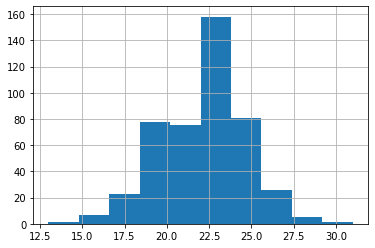

In [28]:
raw_burden["score"].hist()

### Get phenotype information

In [38]:
pheno=pd.read_csv("/nrnb/users/mpagadal/immunotherapy-trials/normal_wxs/phenos/pheno.cibersortx.txt",delimiter="\t")

In [41]:
[x for x in pheno.columns if "CD8"]

['FID',
 'IID',
 'B.cells.naive',
 'B.cells.memory',
 'Plasma.cells',
 'T.cells.CD8',
 'T.cells.CD4.naive',
 'T.cells.CD4.memory.resting',
 'T.cells.CD4.memory.activated',
 'T.cells.follicular.helper',
 'T.cells.regulatory.Tregs',
 'T.cells.gamma.delta',
 'NK.cells.resting',
 'NK.cells.activated',
 'Monocytes',
 'Macrophages.M0',
 'Macrophages.M1',
 'Macrophages.M2',
 'Dendritic.cells.resting',
 'Dendritic.cells.activated',
 'Mast.cells.resting',
 'Mast.cells.activated',
 'Eosinophils',
 'Neutrophils',
 'M1.M2']

In [42]:
# Get M1 and M2 Macrophage Infiltration
mp_mac1=dict(zip(pheno["FID"],pheno["Macrophages.M1"]))
mp_mac2=dict(zip(pheno["FID"],pheno["Macrophages.M2"]))
mp_cd8=dict(zip(pheno["FID"],pheno["T.cells.CD8"]))

In [43]:
raw_burden["M1 Macrophage"]=raw_burden.index.map(mp_mac1)
raw_burden["M2 Macrophage"]=raw_burden.index.map(mp_mac2)
raw_burden["CD8"]=raw_burden.index.map(mp_cd8)

In [44]:
raw_burden=raw_burden[~raw_burden["M1 Macrophage"].isnull()]

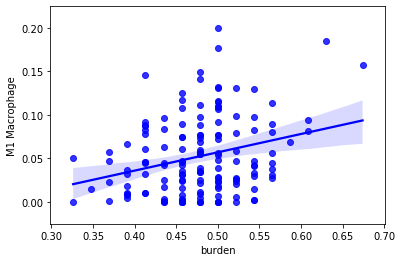

In [45]:
sns.regplot(x="burden",y="M1 Macrophage",data=raw_burden,color="blue")
plt.savefig("../plots/M1.macrophage.burden.pdf")

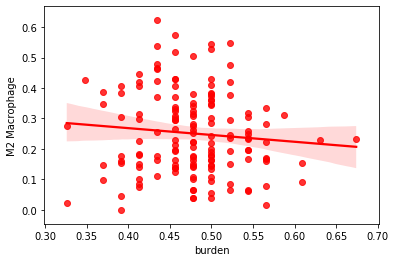

In [46]:
sns.regplot(x="burden",y="M2 Macrophage",data=raw_burden,color="red")
plt.savefig("../plots/M2.macrophage.burden.pdf")

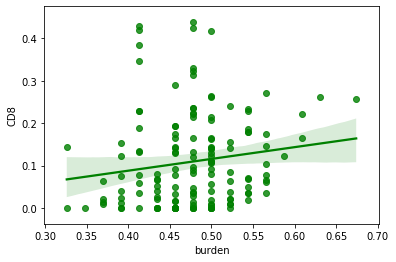

In [47]:
sns.regplot(x="burden",y="CD8",data=raw_burden,color="green")
plt.savefig("../plots/CD8.burden.pdf")

In [48]:
ols = linear_model.LinearRegression()
X=raw_burden["burden"].values.reshape(-1, 1)
y=raw_burden["M1 Macrophage"].values.reshape(-1, 1)
        
X = sm.add_constant(X)
        
model=sm.OLS(y,X)
results=model.fit()

print(results.pvalues[1],results.params[1])

0.0005819017365752515 0.210535716607414


In [50]:
ols = linear_model.LinearRegression()
X=raw_burden["burden"].values.reshape(-1, 1)
y=raw_burden["M2 Macrophage"].values.reshape(-1, 1)
        
X = sm.add_constant(X)
        
model=sm.OLS(y,X)
results=model.fit()

print(results.pvalues[1],results.params[1])

0.23912256322128755 -0.22428921129382853


In [51]:
ols = linear_model.LinearRegression()
X=raw_burden["burden"].values.reshape(-1, 1)
y=raw_burden["CD8"].values.reshape(-1, 1)
        
X = sm.add_constant(X)
        
model=sm.OLS(y,X)
results=model.fit()

print(results.pvalues[1],results.params[1])

0.06901052787651812 0.27746276513489665


In [226]:
raw

,1:1421752:G:A_A,1:10506667:G:A_A,1:10508679:T:C_C,1:79100762:A:T_T,1:89473624:G:A_A,1:89477830:T:C_C,1:89478868:G:A_A,1:89735314:G:A_A,1:150678910:T:C_C,1:161597821:T:G_G,...,19:54848986:C:T_T,19:54849399:T:C_C,19:55025471:C:A_A,19:55145546:T:G_G,19:55173814:G:C_C,19:55174498:T:C_C,19:55175740:C:T_T,19:55175983:T:A_A,19:55225076:C:A_A,21:46328099:T:C_C
FID,,,,,,,,,,,,,,,,,,,,,
SRR478575.sra,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
SRR478621.sra,0,0,0,0,1,0,0,0,0,0,...,2,0,0,0,0,1,1,0,0,1
SRR478648.sra,0,0,0,0,0,1,1,1,0,0,...,0,0,1,0,0,1,0,1,0,1
SRR478798.sra,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,1,1,0,0,0
SRR478821.sra,0,0,0,0,1,0,1,1,0,0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR6511548.sra,0,1,1,1,0,1,1,0,0,1,...,1,0,0,0,0,2,1,0,0,1
SRR6511549.sra,0,0,2,0,1,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
SRR6511550.sra,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,1,0,0,0,2


In [224]:
[x for x in raw.columns if "19:52130638:C:A" in x ]

['19:52130638:C:A_A']

In [110]:
compiled_ciber=compiled_ciber.pivot(index="ID",columns="file",values="BETA")

In [93]:
cols=[x for x in df_plot.columns if "CD" in x]

In [94]:
df_plot=df_plot[cols]

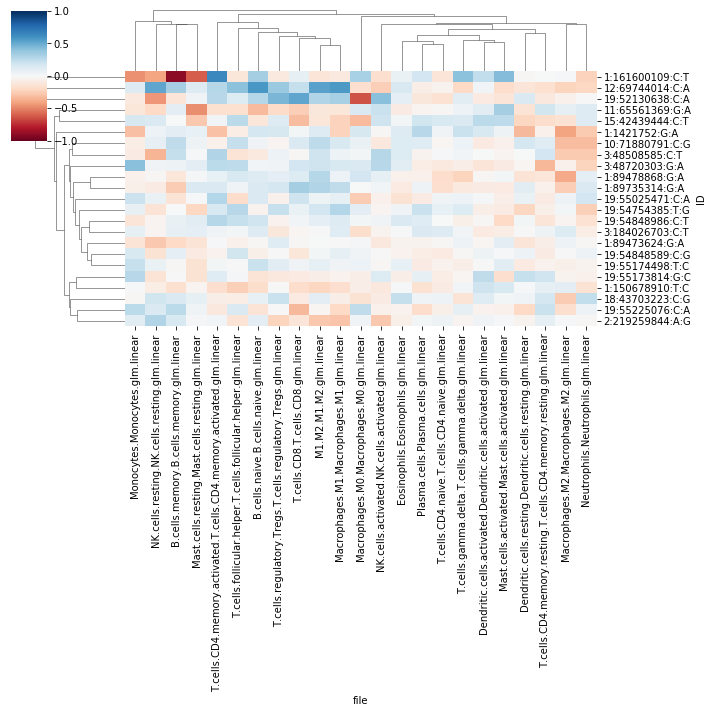

In [98]:
sns.clustermap(df_plot,cmap="RdBu",vmin=-1,vmax=1)

In [111]:
files=[x for x in os.listdir("../associations/rna/") if ".glm.linear" in x]
print(len(files))

15


In [112]:
compiled_rna=pd.DataFrame()

for x in files:
    df=pd.read_csv("../associations/rna/"+x,delimiter="\t",encoding= 'unicode_escape')
    df=df[df["TEST"]=="ADD"].sort_values(by="P")
    df=df[df["ID"].isin(icb[0].tolist())]
    df["file"]=x
    compiled_rna=compiled_rna.append(df)
    

In [113]:
compiled_rna=compiled_rna.pivot(index="ID",columns="file",values="BETA")

In [117]:
df_plot=pd.merge(compiled_rna,compiled_ciber,right_index=True,left_index=True)

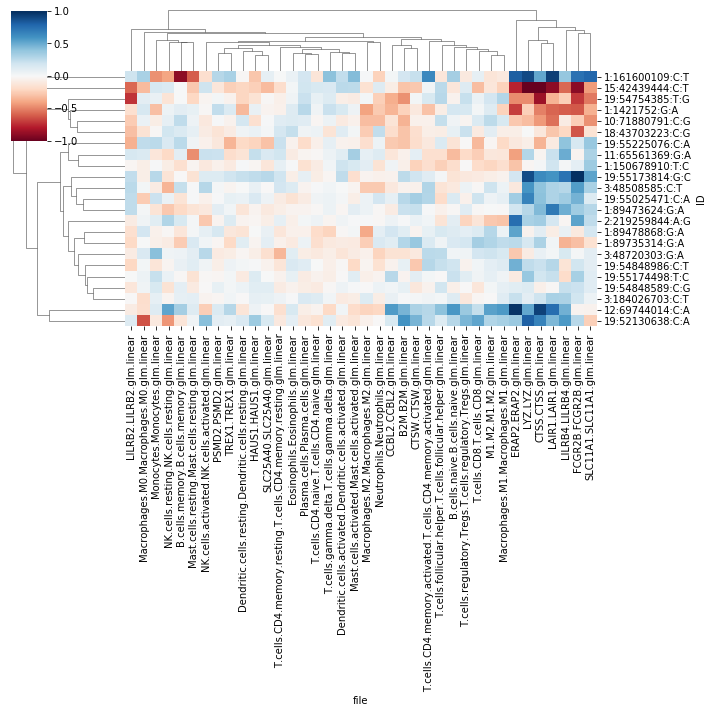

In [118]:
sns.clustermap(df_plot,cmap="RdBu",vmin=-1,vmax=1)

In [45]:
df=pd.read_csv("../associations/metal/all.partial.sd.coding.glm.logistic.hybrid",delimiter="\t",encoding= 'unicode_escape')

In [46]:
df=df[df["TEST"]=="ADD"].sort_values(by="P")

In [48]:
df[df["ID"].isin(icb[0].tolist())]["ID"].tolist()

['12:69744014:C:A',
 '1:150678910:T:C',
 '11:66040049:G:C',
 '3:50196418:C:A',
 '3:184026703:C:T',
 '1:161600109:C:T',
 '19:54687334:C:G',
 '19:54848589:C:G',
 '19:55225076:C:A',
 '19:54752624:T:C',
 '1:89478868:G:A',
 '3:48720303:G:A',
 '10:75607168:T:C',
 '15:44946447:T:C',
 '6:24403549:C:A',
 '8:8999187:G:C',
 '5:96231200:C:T',
 '11:65351364:G:A',
 '19:55145546:T:G',
 '19:55025471:C:A',
 '1:79100762:A:T',
 '11:65561369:G:A',
 '16:89786761:C:T',
 '19:54783923:A:G',
 '5:79809658:A:T',
 '19:55173814:G:C',
 '11:65392357:G:A',
 '19:55174498:T:C',
 '16:23719751:C:T',
 '2:219259844:A:G',
 '21:46328099:T:C',
 '12:113357193:G:A',
 '11:65645354:A:G',
 '11:65646557:C:A',
 '10:71880791:C:G',
 '1:10506667:G:A',
 '5:79811662:G:A',
 '15:45010012:G:C',
 '19:54754385:T:G',
 '5:96413647:G:T',
 '3:119372681:A:C',
 '19:52130638:C:A',
 '12:102119014:T:G',
 '5:96233463:C:G',
 '19:55175983:T:A',
 '3:48587408:A:C',
 '1:161597821:T:G',
 '19:54800371:T:C',
 '19:54783077:C:G',
 '1:89473624:G:A',
 '16:23692405